## MELANOMA DEEP LEARNING IMAGE CLASSIFICATION
### w251 - Fall 2021

![iphone capture](iphone_capture.PNG)

In [12]:
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import sklearn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations
#from util import GradualWarmupSchedulerV2
#import apex
#from apex import amp
#from diag_dataset import get_df_diag, get_transforms, MelanomaDataset
from models import Effnet_Melanoma, Resnest_Melanoma, Seresnext_Melanoma
#from train import get_trans
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
from warmup_scheduler import GradualWarmupScheduler  # https://github.com/ildoonet/pytorch-gradual-warmup-lr

In [13]:
DATA_DIR ='./diagnosis'
IMAGE_SIZE = 256
ENET_TYPE = 'efficientnet_b3'
MODEL_DIR = './weights'
LOG_DIR = './logs'
SUB_DIR = './subs'
# choices=['best', 'best_20', 'final'], default="best")
EVAL = 'best' 
N_TEST = 8
# We only have one GPU on the ol' Jetson
CUDA_VISIBLE_DEVICES = '0'
BATCH_SIZE = 64
NUM_WORKERS = 4
OUT_DIM = 9

In [14]:
os.makedirs(SUB_DIR, exist_ok=True)
os.environ['CUDA_VISIBLE_DEVICES'] = CUDA_VISIBLE_DEVICES

if ENET_TYPE == 'resnest101':
    ModelClass = Resnest_Melanoma
elif ENET_TYPE == 'seresnext101':
    ModelClass = Seresnext_Melanoma
elif 'efficientnet' in ENET_TYPE:
    ModelClass = Effnet_Melanoma
else:
    raise NotImplementedError()

DP = len(os.environ['CUDA_VISIBLE_DEVICES']) > 1

device = torch.device('cuda')

In [15]:
def get_trans(img, I):

    if I >= 4:
        img = img.transpose(2, 3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)

In [16]:
class MelanomaDataset(Dataset):
    def __init__(self, csv, mode, transform=None):

        self.csv = csv.reset_index(drop=True)
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):

        row = self.csv.iloc[index]

        image = cv2.imread(row.filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)

        data = torch.tensor(image).float()

        if self.mode == 'test':
            return data
        else:
            return data, torch.tensor(self.csv.iloc[index].target).long()

In [17]:
def get_transforms(image_size):

    transforms_val = albumentations.Compose([
        albumentations.Resize(image_size, image_size),
        albumentations.Normalize()
    ])

    return transforms_val


In [18]:
def get_df_diag(data_dir):

    # diag data
    df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
    df_diag = pd.read_csv(os.path.join(data_dir, 'diag.csv'))
    df_diag['filepath'] = df_diag['image_name'].apply(lambda x: os.path.join(data_dir, 'diag', f'{x}.jpg'))
    
    # class mapping
    diagnosis2idx = {d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique()))}
    df_diag['target'] = df_train['diagnosis'].map(diagnosis2idx)
    mel_idx = diagnosis2idx['melanoma']

    return df_diag, mel_idx

In [19]:

class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [20]:
def main():

    df_diag, mel_idx = get_df_diag(DATA_DIR)
    
    #print('printing df_diag')
    #print(df_diag)
    #print('printing mel_idx')
    #print(mel_idx)

    transforms_val = get_transforms(IMAGE_SIZE)

    #if DEBUG:
    #    df_test = df_test.sample(BATCH_SIZE * 3)
    dataset_diag = MelanomaDataset(df_diag, 'test', transform=transforms_val)
    diag_loader = torch.utils.data.DataLoader(dataset_diag, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    # load model
    models = []
    for fold in range(5):

        if EVAL == 'best':
            model_file =  os.path.join(MODEL_DIR, 'baseline-model-1_final_fold4.pth') 
        elif EVAL == 'best_20': 
            model_file = os.path.join(MODEL_DIR, 'best_20_model.pth')
        if EVAL == 'final':
            model_file = os.path.join(MODEL_DIR, 'final_model.pth')

        model = ModelClass(
            ENET_TYPE,
            out_dim=OUT_DIM
        )
        model = model.to(device)

        try:  # single GPU model_file
            model.load_state_dict(torch.load(model_file), strict=True)
        except:  # multi GPU model_file
            state_dict = torch.load(model_file)
            state_dict = {k[7:] if k.startswith('module.') else k: state_dict[k] for k in state_dict.keys()}
            model.load_state_dict(state_dict, strict=True)
        
        if len(os.environ['CUDA_VISIBLE_DEVICES']) > 1:
            model = torch.nn.DataParallel(model)

        model.eval()
        models.append(model)

    # predict
    PROBS = []
    with torch.no_grad():
        for (data) in tqdm(diag_loader):
            data = data.to(device)
            probs = torch.zeros((data.shape[0], OUT_DIM)).to(device)
            for model in models:
                for I in range(N_TEST):
                    l = model(get_trans(data, I))
                    probs += l.softmax(1)

            probs /= N_TEST
            probs /= len(models)

            PROBS.append(probs.detach().cpu())

    PROBS = torch.cat(PROBS).numpy()
    
    #print('printing PROBS')
    #print(PROBS)
    
    # save cvs
    df_diag['target'] = PROBS[:, mel_idx]
    df_diag[['image_name', 'target']].to_csv(os.path.join(SUB_DIR, 'results.csv'), index=False)
    
    images = df_diag['filepath']

    print("")
    
    print("OUTPUT RESULTS")
    
    fig = plt.figure(figsize=(20,5))
    for i in range(len(images)):
        ax = fig.add_subplot(1, len(images), i+1)
        ax.axis('off')
        img = Image.open(images[i])
        prob = df_diag['target'][i]
        if (prob > 0) & (prob < .005) :
            border_img = ImageOps.expand(img, border=15, fill='lightgreen')
        if (prob > .005) & (prob < .09) :
            border_img = ImageOps.expand(img, border=15, fill='yellow')   
        if (prob > .09) & (prob < 1) :
            border_img = ImageOps.expand(img, border=15, fill='indianred')   
        imgplot = plt.imshow(border_img)
        ax.set_title("melanoma probability "+str(round(float(df_diag['target'][i]*100),2))+"%")

## CAPTURING IMAGES FOR DIAGNOSIS


INPUT IMAGES FOR DIAGOSIS


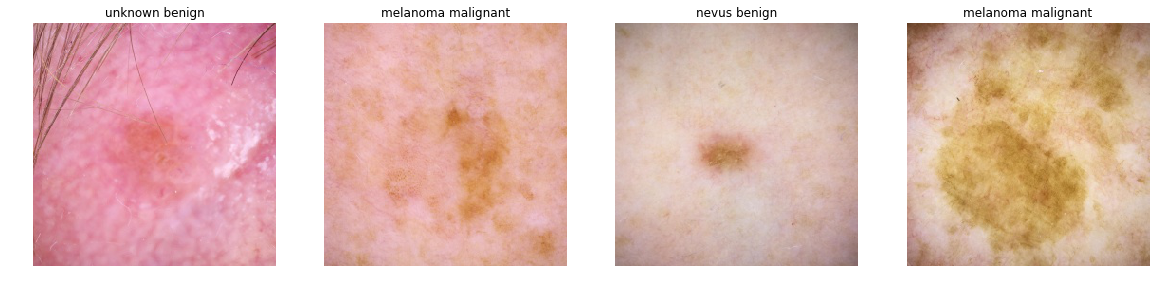

In [21]:
df_diag1 = pd.read_csv(os.path.join(DATA_DIR, 'diag.csv'))
#print(DATA_DIR)
#print('printing df_diag1')
#print(df_diag1)

#df_diag, mel_idx = get_df_diag(DATA_DIR)

# diag data
df_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
df_diag = pd.read_csv(os.path.join(DATA_DIR, 'diag.csv'))
df_diag['filepath'] = df_diag['image_name'].apply(lambda x: os.path.join(DATA_DIR, 'diag', f'{x}.jpg'))

# class mapping
diagnosis2idx = {d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique()))}
#print('printing diagnosis2idx')
#print(diagnosis2idx)

df_diag['diagnosis_idx'] = df_diag['diagnosis'].map(diagnosis2idx)

mel_idx = diagnosis2idx['melanoma']

#print(DATA_DIR)
#print('printing df_diag')
#print(df_diag)

images = df_diag['filepath']

print("INPUT IMAGES FOR DIAGOSIS")
fig = plt.figure(figsize=(20,5))
for i in range(len(images)):
    ax = fig.add_subplot(1, len(images), i+1)
    ax.axis('off')
    img = Image.open(images[i])
    #if df_diag['target'][i] < 1:
        #border_img = ImageOps.expand(img, border=25, fill='lightgreen')
    #else:
        #border_img = ImageOps.expand(img, border=25, fill='indianred')
    #imgplot = plt.imshow(border_img)
    imgplot = plt.imshow(img)
    ax.set_title(str(df_diag['diagnosis'][i])+" "+str(df_diag['benign_malignant'][i]))

## SCANNING IMAGES FOR MELANOMA

100%|██████████| 1/1 [00:13<00:00, 13.17s/it]



OUTPUT RESULTS


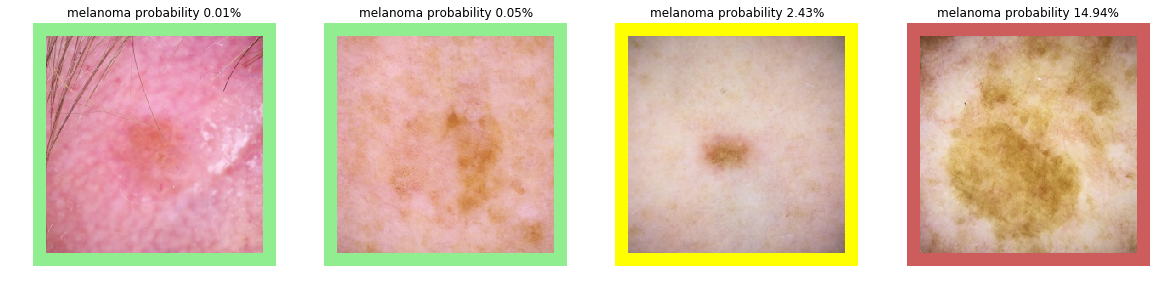

In [22]:
main()